# Exploitation of simulation algorithm results

In this basic example we are going to retrieve all the results proposed by probability simulation algorithms:

- the probability estimate
- the estimator variance
- the confidence interval
- the convergence graph of the estimator
- the stored input and output numerical samples
- importance factors

In [24]:
from __future__ import print_function
import openturns as ot

In [25]:
# create the joint distribution of the parameters
distribution_R = ot.LogNormalMuSigma(300.0, 30.0, 0.0).getDistribution()
distribution_F = ot.Normal(75e3, 5e3)
marginals = [distribution_R, distribution_F]
distribution = ot.ComposedDistribution(marginals)

In [26]:
# create the model
model = ot.SymbolicFunction(['R', 'F'], ['R-F/(pi_*100.0)'])

In [27]:
modelCallNumberBefore = model.getEvaluationCallsNumber()
modelGradientCallNumberBefore = model.getGradientCallsNumber()
modelHessianCallNumberBefore = model.getHessianCallsNumber()

In [28]:
# To have access to the input and output samples
# after the simulation, activate the History mechanism
model = ot.MemoizeFunction(model)

# Remove all the values stored in the history mechanism
# Care : it is done regardless the status of the History mechanism
model.clearHistory()

In [29]:
# create the event we want to estimate the probability
vect = ot.RandomVector(distribution)
G = ot.RandomVector(model, vect)
event = ot.Event(G, ot.Less(), 0.0)

In [30]:
# create a Monte Carlo algorithm
experiment = ot.MonteCarloExperiment()
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumCoefficientOfVariation(0.1)
algo.setMaximumStandardDeviation(0.001)
algo.setMaximumOuterSampling(int(1e4))

In [31]:
# Define the HistoryStrategy to store the values of $P_n$ and $\sigma_n$
# used ot draw the convergence graph
# Compact strategy : N points
N = 1000
algo.setConvergenceStrategy(ot.Compact(N))
algo.run()

In [32]:
# retrieve result structure
result = algo.getResult()

In [33]:
# Display the simulation event probability
result.getProbabilityEstimate()

0.030265210608424305

In [34]:
#  Criteria 3 : Display the Standard Deviation of the estimator
result.getStandardDeviation()

0.0030261072874587947

In [35]:
# Display the variance of the simulation probability estimator
result.getVarianceEstimate()

9.157325315211225e-06

In [36]:
#  Criteria 2 : Display the number of iterations of the simulation
result.getOuterSampling()

3205

In [37]:
# Display the total number of evaluations of the model
result.getOuterSampling() * result.getBlockSize()

3205

In [38]:
# Save the number of calls to the model, its gradient and hessian done so far
modelCallNumberAfter = model.getEvaluationCallsNumber()
modelGradientCallNumberAfter = model.getGradientCallsNumber()
modelHessianCallNumberAfter = model.getHessianCallsNumber()

# Display the number of iterations executed and
# the number of evaluations of the model
modelCallNumberAfter - modelCallNumberBefore


3205

In [39]:
# Get the mean point in event  domain
# care : only for Monte Carlo and LHS sampling methods
result.getMeanPointInEventDomain()

class=Point name=Unnamed dimension=2 values=[247.667,81157.4]

In [40]:
# Get the associated importance factors
# care : only for Monte Carlo and LHS sampling methods
result.getImportanceFactors()

class=PointWithDescription name=Unnamed dimension=2 description=[X0,X1] values=[0.697926,0.302074]

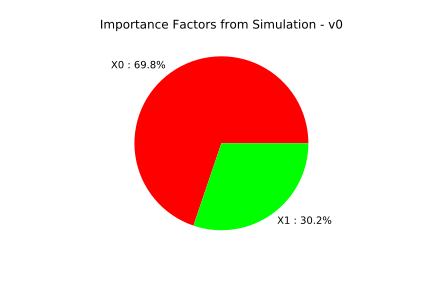

In [41]:
result.drawImportanceFactors()

In [42]:
# Display the confidence interval length centered around the
# MonteCarlo probability MCProb
# IC = [Probability - 0.5*length, Probability + 0.5*length]
# level 0.95
probability = result.getProbabilityEstimate()
length95 = result.getConfidenceLength(0.95)
print("0.95 Confidence Interval length = ", length95)
print("IC at 0.95 = [", probability - 0.5*length95, "; ", probability + 0.5*length95, "]")

0.95 Confidence Interval length =  0.011862122593546867
IC at 0.95 = [ 0.02433414931165087 ;  0.03619627190519774 ]


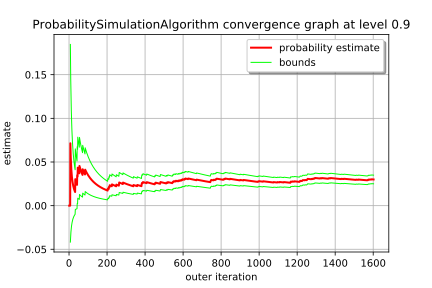

In [43]:
# Draw the convergence graph and the confidence interval of level alpha
# By default, alpha = 0.95
alpha = 0.90
algo.drawProbabilityConvergence(alpha)

In [44]:
# Get the numerical samples of the input and output random vectors
# stored according to the History Strategy specified
# and used to evaluate the probability estimator and its variance
inputSampleStored = model.getInputHistory()
outputSampleStored = model.getOutputHistory()
inputSampleStored

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=3205 dimension=2 data=[[283.944,78982.5],[305.679,74983.5],[292.277,78322.9],...,[281.645,75644.6],[336.363,68478.5],[227.882,83788]]

In [45]:
# Get the values of the estimator and its variance
# stored according to the History Strategy specified
# and used to draw the convergence graph
estimator_probability_sample = algo.getConvergenceStrategy().getSample()[0]
estimator_variance_sample = algo.getConvergenceStrategy().getSample()[1]
print(estimator_probability_sample, estimator_variance_sample)

[0,-1] [0,-1]
